# 필요 패키지 로드

In [1]:
#필요 패키지 로드
import glob
import os.path
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras 
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf
import pickle
import random
from datetime import datetime
from pytz import timezone
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from matplotlib import figure
from tensorflow.keras.utils import plot_model

tf.random.set_seed(777) #하이퍼파라미터 튜닝을 위해 실행시 마다 변수가 같은 초기값 가지게 하기

C:\Users\HWANG\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\HWANG\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\HWANG\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 데이터 전처리

In [ ]:
# 1. 확장자(mp3->wav) 변환
##리눅스 환경의 경우, mp3파일 위치에서 for f in *.mp3; do mv -- "$f" "${f%.mp3}.wav"; done 명령으로 쉽게 변경 가능

#mp3파일 위치 지정
files = glob.glob("G:/내 드라이브/210512_voicecrawling/voice_gtts_integrate/*.mp3")
for x in files:
    #확장자만 따로 떨어뜨림. 예시: os.path.splitext('c:\temp\python\data.txt') >> (‘c:\\temp\\python\\data’, ‘.txt’)
    if not os.path.isdir(x): 
        filename = os.path.splitext(x)
        try:
            os.rename(x, filename[0]+'.wav') #원본은 사라짐. 기존 파일확장자 -> wav로 변경됨
        except:
            pass

In [ ]:
# 2. wav->melspectrogram 변환(CNN 이미지 입력용도)
#데이터 처리가 오래 걸려 시간 측정용
print("Start code: ", datetime.now(timezone('Asia/Seoul')).strftime('%Y-%m-%d %H:%M:%S'))

# 데이터 읽기(.tsv파일에 음성데이터 파일명, 경로명 등 정의)
date = pd.read_csv("/home/hwang/cv-corpus-6.1-singleword/en/validated.tsv", delimiter="\t", engine='python')
path = "./cv-corpus-6.1-singleword/en/clips/"

col = "accent"
filename = "path"

us = "us"
uk = "england"
D_path = "/gdrive/MyDrive/210514_voiceclassification/D_210527_cvval_newmodel.pickle"

#학습 데이터 준비
D = []

for i in range(len(data)):
    country = data.iloc[i][col]
    if country == us or country == uk:
        try:
            y, sr = librosa.load(path+data.iloc[i][filename][:-4]+'.wav', duration=0.984)
            ps = librosa.feature.melspectrogram(y=y, sr=sr) # 0.984초로 불러와진 경우, ps.shape=(128, 43)
            while ps.shape[1] < 43: # 0.984초 이하 데이터 ps 열 크기 늘리기 
                ps = np.c_[ps, ps[:, :43 - ps.shape[1]]]
            if country == us: #us: label 0
                D.append( (ps, 0) )
            else: #uk: label 1
                D.append( (ps, 1) )
        except FileNotFoundError as e:
            print(e)

print("Number of samples: ", len(D))

#.pickle파일로 저장
with open(D_path) as fw:
    pickle.dump(D, fw)
    
print("Finish code: ", datetime.now(timezone('Asia/Seoul')).strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
# 3. 데이터 증강
#데이터 처리가 오래 걸려 시간 측정용
print("Start code: ", datetime.now(timezone('Asia/Seoul')).strftime('%Y-%m-%d %H:%M:%S'))

# 데이터 읽기(.tsv파일에 음성데이터 파일명, 경로명 등 정의)
date = pd.read_csv("/home/hwang/cv-corpus-6.1-singleword/en/validated.tsv", delimiter="\t", engine='python')
path = "./cv-corpus-6.1-singleword/en/clips/"

col = "accent"
filename = "path"

us = "us"
uk = "england"
D_path = "/gdrive/MyDrive/210514_voiceclassification/D_210601_cvval_newmodel_aug.pickle"

#학습 데이터 준비
D = []

#3-1. 데이터 길이를 1.07배 빠른 속도로 변형
rate = 1.07
for i in range(len(data)):
    country = data.iloc[i][col]
    if country == us or country == uk:
        try:
            y, sr = librosa.load(path+data.iloc[i][filename][:-4]+'.wav')
            y_changed = librosa.effects.time_stretch(y, rate=rate)
            ps = librosa.feature.melspectrogram(y=y_changed, sr=sr)
            if ps.shape[1] > 43: #43보다 길어진 경우, 43만큼 자르기
                ps = np.c_[ps, ps[:, :43]]
            while ps.shape[1] < 43: # 0.984초 이하 데이터 ps 열 크기 늘리기 
                ps = np.c_[ps, ps[:, :43 - ps.shape[1]]]
            if country == us: #us: label 0
                D.append( (ps, 0) )
            else: #uk: label 1
                D.append( (ps, 1) )
        except FileNotFoundError as e:
            print(e)

#3-2. 데이터 음성을 2키 올려 변조
n_steps = 2
for i in range(len(data)):
    country = data.iloc[i][col]
    if country == us or country == uk:
        try:
            y, sr = librosa.load(path+data.iloc[i][filename][:-4]+'.wav', duration=0.984)
            y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
            ps = librosa.feature.melspectrogram(y=y_changed, sr=sr)
            if ps.shape[1] > 43: #43보다 길어진 경우, 43만큼 자르기
                ps = np.c_[ps, ps[:, :43]]
            while ps.shape[1] < 43: # 0.984초 이하 데이터 ps 열 크기 늘리기 
                ps = np.c_[ps, ps[:, :43 - ps.shape[1]]]
            if country == us: #us: label 0
                D.append( (ps, 0) )
            else: #uk: label 1
                D.append( (ps, 1) )
        except FileNotFoundError as e:
            print(e)

#3-3. 데이터 음성을 2.5키 올려 변조
n_steps = 2.5
for i in range(len(data)):
    country = data.iloc[i][col]
    if country == us or country == uk:
        try:
            y, sr = librosa.load(path+data.iloc[i][filename][:-4]+'.wav')
            y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_steps)
            ps = librosa.feature.melspectrogram(y=y_changed, sr=sr)
            if ps.shape[1] > 43: #43보다 길어진 경우, 43만큼 자르기
                ps = np.c_[ps, ps[:, :43]]
            while ps.shape[1] < 43: # 0.984초 이하 데이터 ps 열 크기 늘리기 
                ps = np.c_[ps, ps[:, :43 - ps.shape[1]]]
            if country == us: #us: label 0
                D.append( (ps, 0) )
            else: #uk: label 1
                D.append( (ps, 1) )
        except FileNotFoundError as e:
            print(e)

print("Number of samples: ", len(D))

#.pickle파일로 저장
with open(D_path) as fw:
    pickle.dump(D, fw)
    
print("Finish code: ", datetime.now(timezone('Asia/Seoul')).strftime('%Y-%m-%d %H:%M:%S'))

# 데이터 로드

In [ ]:
with open("/gdrive/MyDrive/210514_voiceclassification/D_210527_cvval_newmodel.pickle", "rb") as fr:
  D = pickle.load(fr)

In [ ]:
with open("/gdrive/MyDrive/210514_voiceclassification/D_210601_cvval_aug.pickle", "rb") as fr:
  D2 = pickle.load(fr)

# 훈련, 테스트 데이터셋 분할

In [ ]:
#train, test set split
dataset = D+D2
random.shuffle(dataset)

train = dataset[:18000] #18000개 데이터는 훈련용 
test = dataset[18000:] # 나머지 2584개 데이터는 테스트용

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# for sigmoid: One-Hot encoding for classes
# Our vectorized labels(에러 방지: https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape)
y_train_sig = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_sig = np.asarray(y_test).astype('float32').reshape((-1,1))


print(len(train), len(test))

18000 2584


# 최종모델 c_model88_4

start code:  2021-06-08 15:29:39
Epoch 1/120
141/141 [==============================] - 17s 115ms/step - loss: 0.6916 - accuracy: 0.7158 - val_loss: 0.6012 - val_accuracy: 0.7194
Epoch 2/120
141/141 [==============================] - 16s 115ms/step - loss: 0.5887 - accuracy: 0.7248 - val_loss: 0.5913 - val_accuracy: 0.7198
Epoch 3/120
141/141 [==============================] - 16s 113ms/step - loss: 0.5808 - accuracy: 0.7257 - val_loss: 0.5728 - val_accuracy: 0.7202
Epoch 4/120
141/141 [==============================] - 16s 112ms/step - loss: 0.5784 - accuracy: 0.7260 - val_loss: 0.5719 - val_accuracy: 0.7202
Epoch 5/120
141/141 [==============================] - 16s 112ms/step - loss: 0.5705 - accuracy: 0.7265 - val_loss: 0.5662 - val_accuracy: 0.7202
Epoch 6/120
141/141 [==============================] - 16s 113ms/step - loss: 0.5665 - accuracy: 0.7277 - val_loss: 0.5635 - val_accuracy: 0.7210
Epoch 7/120
141/141 [==============================] - 16s 114ms/step - loss: 0.5654 - accu

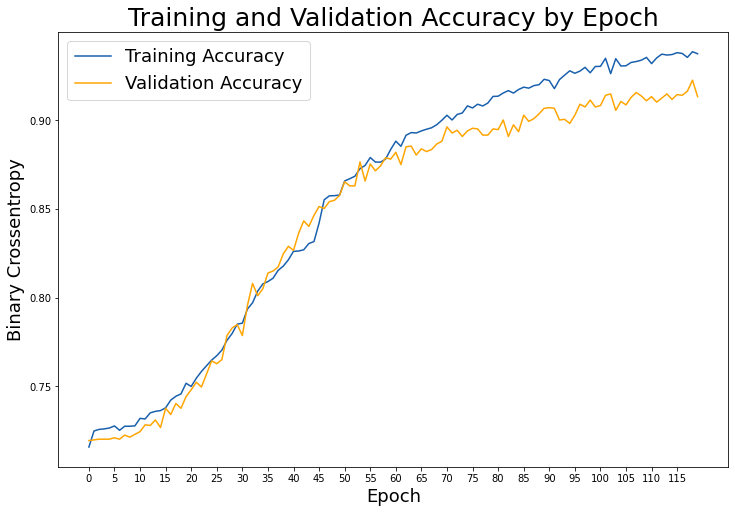

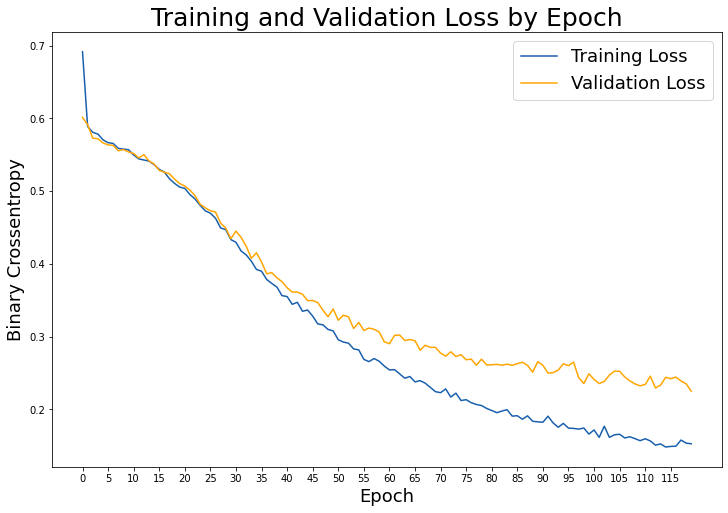

In [ ]:
#2. 모델 작성
#컨볼루션층 필터 이동 보폭 기본: (1, 1), 활성함수  ReLU
n_filter = 96 #컨볼루션2~3층 필터 개수
filter_size = (5, 4) #컨볼루션 1~3층 필터 크기
p_size = (2, 2) #맥스 풀링 1~2층 풀링창 크기
model = Sequential() #순차적 모델 정의
input_shape=(128, 128, 1) #입력층 데이터 크기

#컨볼루션 1층 24개 커널
model.add(Conv2D(24, filter_size, input_shape=input_shape))
model.add(MaxPooling2D(p_size))
model.add(Activation('relu'))

model.add(Conv2D(n_filter), filter_size, padding="same")) #연산하면서 날아가는 테두리 값 채우기: 가장 테두리쪽의 값을 그대로 이용
model.add(MaxPooling2D(p_size))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5)) #과적합 방지 dropout 비율 50%

model.add(Conv2D(n_filter, filter_size, padding="same"))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Flatten()) # 전결합층 연산을 위한 2->1차원 변환
model.add(Dropout(rate=0.5))

model.add(Dense(64)) #전결합층 64개 커널
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1)) #출력층
model.add(Activation('sigmoid'))

print("start code: ", datetime.now(timezone('Asia/Seoul')).strftime('%Y-%m-%d %H:%M:%S'))
#모델 컴파일
model.compile(
	optimizer="Adam", #최적화 함수: Adam
	loss="binary_crossentropy", #손실함수: 이진분류이므로 이진교차엔트로피
	metrics=['accuracy']) # 학습 성능평가 척도: 정확도

#모델 적합
history = model.fit(
	x=X_train, 
	y=y_train_sig,
    epochs=120, #120번 반복학습
    batch_size=128, #학습시 이용되는 훈련데이터수
    validation_data= (X_test, y_test_sig)) #학습 검증용 데이터

#모델 성능평가
score = model.evaluate(
	x=X_test,
	y=y_test_sig)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("finish code: ", datetime.now(timezone('Asia/Seoul')).strftime('%Y-%m-%d %H:%M:%S'))

##정확도, 손실값 확인용 그래프
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks(range(0,120,5), range(0,120,5))

plt.legend(fontsize = 18)
plt.show();

# Check out our train loss and validation loss over epochs.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(val_loss, label='Validation Loss', color='orange')

# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks(range(0,120,5), range(0,120,5))

plt.legend(fontsize = 18)
plt.show();

# 만든 모델 다른 데이터에 적용

In [ ]:
#test at other data
with open("/gdrive/MyDrive/210514_voiceclassification/D_210608_test.pickle", "rb") as fr:
  D = pickle.load(fr)
  
#train, test set split
random.shuffle(D)
X_test, y_test = zip(*D)

# Reshape for CNN input
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# for sigmoid: One-Hot encoding for classes
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

#test
score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("finish code: ", datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f\n'))

41/41 [==============================] - 1s 12ms/step - loss: 1.8905 - accuracy: 0.5039
Test loss: 1.8904929161071777
Test accuracy: 0.5038880109786987
finish code:  2021-06-08 07:01:56.109175



In [ ]:
# 모델 저장
model.save("/gdrive/MyDrive/voiceclassification_model/c_model88_4")

INFO:tensorflow:Assets written to: /gdrive/MyDrive/voiceclassification_model/c_model88_4/assets


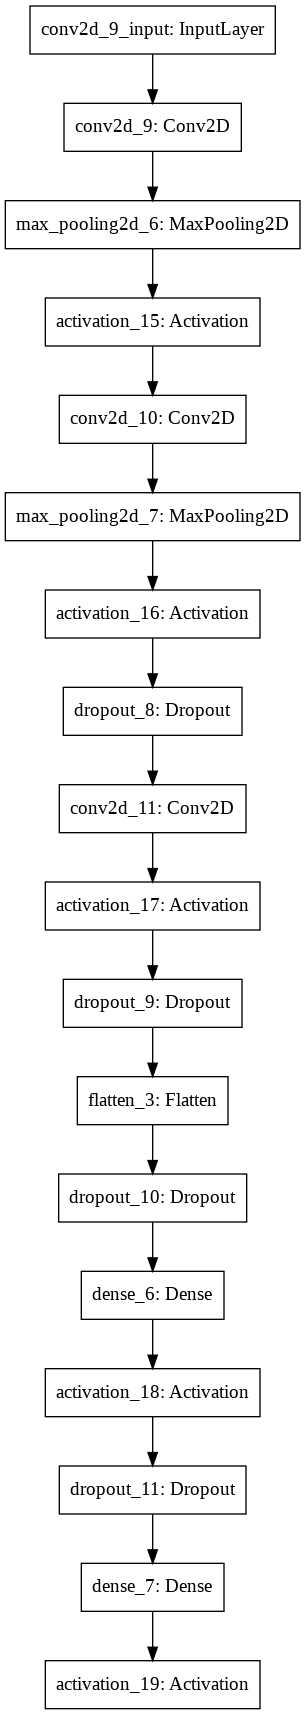

In [ ]:
# 저장된 모델 로드
model = keras.models.load_model("/gdrive/MyDrive/voiceclassification_model/c_model88_4")

#모델 그림 저장
plot_model(model, to_file='/gdrive/MyDrive/model.png')